In [ ]:
# === 自动扫描 50 组（在线/离线）权重，计算白化距离并给出 η 建议范围 ===
import os, re, math, glob, json
from pathlib import Path
import torch
import numpy as np
import pandas as pd

# 1) 填你的根路径
ROOT = Path("/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random50_r8_savemodels_aglr5e-5").resolve()
assert ROOT.exists(), f"根目录不存在: {ROOT}"

# 2) 白化方式（要与认证/采样保持一致）
WHITEN_MODE = "block-fixed"     # "block-fixed"（默认）或 "rms-per-param"

# A) 分块固定 σ（与你前面采样一致）
SIGMA_UNET = 1e-3
SIGMA_TEXT = 1e-3

# B) 逐参数 RMS（若切换到这个模式，设置两个 alpha；σ_i = alpha * RMS(W_i)）
# ALPHA_UNET = 0.03
# ALPHA_TEXT = 0.01

# ------------------------------------------------------------
def _strip_module_prefix(sd):
    if any(k.startswith("module.") for k in sd.keys()):
        return {k.replace("module.", "", 1): v for k, v in sd.items()}
    return sd

def load_sd(pth):
    obj = torch.load(pth, map_location="cpu")
    # 允许 {state_dict: ...} 包装
    if isinstance(obj, dict) and "state_dict" in obj and isinstance(obj["state_dict"], dict):
        obj = obj["state_dict"]
    return _strip_module_prefix(obj)

def tensor_rms(t: torch.Tensor):
    if t.numel() == 0:
        return torch.tensor(0.0, dtype=t.dtype)
    return (t.float().pow(2).mean().sqrt().clamp_min(1e-12)).to(t.dtype)

@torch.no_grad()
def diff_norm_whitened(off_sd: dict, on_sd: dict, *, mode: str, alpha: float=None, sigma_fixed: float=None):
    """
    返回：白化后的 L2 范数 || (on - off)/σ ||_2
    - mode="block-fixed": σ 为一个标量（本块统一的 σ）
    - mode="rms-per-param": 每张量 σ_t = alpha * RMS(参考张量)
    仅对两边都存在且 shape 一致的 key 累加。
    """
    s2 = 0.0
    n_match = 0
    n_missing = 0
    for k, w_off in off_sd.items():
        w_on = on_sd.get(k, None)
        if w_on is None or w_on.shape != w_off.shape:
            n_missing += 1
            continue
        diff = (w_on - w_off).float()
        if mode == "block-fixed":
            sigma = torch.as_tensor(sigma_fixed, dtype=torch.float32)
            s2 += float((diff / sigma).pow(2).sum().item())
        elif mode == "rms-per-param":
            # 以 off 权重的 RMS 为参考，也可换成 on 或两者均值
            sigma_t = (tensor_rms(w_off) * float(alpha)).float().clamp_min(1e-12)
            s2 += float((diff / sigma_t).pow(2).sum().item())
        else:
            raise ValueError("unknown mode")
        n_match += 1
    return math.sqrt(max(s2, 0.0)), n_match, n_missing

def latest_checkpoint_dir(train_output_dir: Path):
    # 形如 checkpoint-2000、checkpoint-3000 ... 选步数最大的
    cands = sorted([p for p in train_output_dir.glob("checkpoint-*") if p.is_dir()],
                   key=lambda p: int(re.findall(r"checkpoint-(\d+)", p.name)[0]),
                   reverse=True)
    return cands[0] if len(cands) else None

def find_pairs(root: Path):
    """返回每个 id 的在线/离线 UNet/TextEncoder 路径字典列表"""
    pairs = []
    for d in sorted(root.glob("exp_data_ASPL-id*-r8-steps50-*")):
        if not d.is_dir():
            continue
        # 在线
        on_unet = d / "models" / "50" / "unet.pth"
        on_text = d / "models" / "50" / "text_encoder.pth"
        # 离线（diffusers）
        train_out = d / "train_output"
        ckpt_dir = latest_checkpoint_dir(train_out) if train_out.exists() else None
        off_unet = ckpt_dir / "unet" / "diffusion_pytorch_model.bin" if ckpt_dir else None
        off_text = ckpt_dir / "text_encoder" / "pytorch_model.bin" if ckpt_dir else None

        ok = all([on_unet and on_unet.exists(),
                  on_text and on_text.exists(),
                  off_unet and off_unet.exists(),
                  off_text and off_text.exists()])
        if not ok:
            print(f"[WARN] 跳过（缺文件）: {d}")
            continue

        # 提取 id
        m = re.search(r"exp_data_ASPL-id(\d+)-r8-steps50-\d+", d.name)
        id_ = int(m.group(1)) if m else None
        pairs.append({
            "id": id_,
            "root": str(d),
            "on_unet": str(on_unet),
            "on_text": str(on_text),
            "off_unet": str(off_unet),
            "off_text": str(off_text),
            "ckpt": ckpt_dir.name if ckpt_dir else None
        })
    return sorted(pairs, key=lambda x: (x["id"] if x["id"] is not None else 1e9))

pairs = find_pairs(ROOT)
print(f"发现配对: {len(pairs)} 组")
assert len(pairs) > 0, "没有发现有效的模型配对，请检查路径"

rows = []
for it in pairs:
    id_ = it["id"]
    # 加载
    onU  = load_sd(it["on_unet"])
    onT  = load_sd(it["on_text"])
    offU = load_sd(it["off_unet"])
    offT = load_sd(it["off_text"])

    # 计算白化距离：以“离线”为球心，度量“在线→离线”的偏移
    if WHITEN_MODE == "block-fixed":
        du, mu, mu_miss = diff_norm_whitened(offU, onU, mode="block-fixed", sigma_fixed=SIGMA_UNET)
        dt, mt, mt_miss = diff_norm_whitened(offT, onT, mode="block-fixed", sigma_fixed=SIGMA_TEXT)
    else:
        du, mu, mu_miss = diff_norm_whitened(offU, onU, mode="rms-per-param", alpha=ALPHA_UNET)
        dt, mt, mt_miss = diff_norm_whitened(offT, onT, mode="rms-per-param", alpha=ALPHA_TEXT)

    d_whiten = math.sqrt(du**2 + dt**2)
    rows.append({
        "id": id_,
        "dir": it["root"],
        "ckpt": it["ckpt"],
        "d_on_to_off": d_whiten,
        "du_on_to_off": du,
        "dt_on_to_off": dt,
        "unet_keys_matched": mu,
        "unet_keys_missing": mu_miss,
        "text_keys_matched": mt,
        "text_keys_missing": mt_miss,
        "whiten_mode": WHITEN_MODE
    })

df = pd.DataFrame(rows).sort_values("id").reset_index(drop=True)
display(df.head(), df.describe())

# —— 分位数建议（白化坐标下）——
valid = df["d_on_to_off"].replace([np.inf, -np.inf], np.nan).dropna().to_numpy()
assert valid.size > 0
p50 = float(np.quantile(valid, 0.50))
p90 = float(np.quantile(valid, 0.90))
p95 = float(np.quantile(valid, 0.95))
p99 = float(np.quantile(valid, 0.99))
print(f"[白化距离分位] P50={p50:.4f}, P90={p90:.4f}, P95={p95:.4f}, P99={p99:.4f}")

# —— 生成 η 建议网格 —— 
# 说明：在本白化坐标下，认证用 σ=1（因为我们已把不同块除以各自 σ）；η 直接与 q_upper 通过 η/σ=η 发生作用。
eta_max = p95 * 1.10   # P95 + 10% 裕量
# 细分 0 ~ eta_max（含端点） + 若干通用参考点
base = np.linspace(0.0, eta_max, 12).tolist()
extras = [0.1, 0.2, 0.5, 1.0]    # 与 σ=1 的量级点；若 eta_max < 0.2 这些会被截断
etas = sorted(set([round(x, 6) for x in base + [e for e in extras if e <= max(eta_max, 1e-6)]]))

print("\n【建议的 η 列表】")
print(etas)

# —— 保存结果 —— 
out_dir = Path("/data/home/yekai/github/DiffAdvPerturbationBench/PUEs/find_eta_out")
out_dir.mkdir(parents=True, exist_ok=True)
df.to_csv(out_dir / "whitened_distances.csv", index=False)
with open(out_dir / "etas_suggested.json", "w") as f:
    json.dump({
        "etas": etas,
        "stats": {"P50": p50, "P90": p90, "P95": p95, "P99": p99},
        "whiten_mode": WHITEN_MODE,
        "sigma_unet": SIGMA_UNET,
        "sigma_text": SIGMA_TEXT
    }, f, indent=2)
print(f"\n已保存：\n- {out_dir/'whitened_distances.csv'}\n- {out_dir/'etas_suggested.json'}")

发现配对: 50 组


/tmp/ipykernel_3261480/3887358639.py:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(pth, map_location="cpu")


#### 单组可视化

In [ ]:
import torch, re, math
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ===== 默认参数 =====
SIGMA_UNET = 1e-3
SIGMA_TEXT = 1e-3
ROOT = Path("/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random40_r8_savemodels_robust1e-3_0.4_0.8_aglr5e-5_delta10theta10")

def _strip_module_prefix(sd):
    if any(k.startswith("module.") for k in sd.keys()):
        return {k.replace("module.", "", 1): v for k, v in sd.items()}
    return sd

def load_sd(pth):
    obj = torch.load(pth, map_location="cpu")
    if isinstance(obj, dict) and "state_dict" in obj:
        obj = obj["state_dict"]
    return _strip_module_prefix(obj)

def latest_checkpoint_dir(train_output_dir: Path):
    cands = sorted([p for p in train_output_dir.glob("checkpoint-*") if p.is_dir()],
                   key=lambda p: int(re.findall(r"checkpoint-(\d+)", p.name)[0]),
                   reverse=True)
    return cands[0] if len(cands) else None

def find_pairs(root: Path):
    pairs = []
    for d in sorted(root.glob("exp_data_ASPL-id*-r8-steps50-*")):
        if not d.is_dir():
            continue
        on_unet = d / "models" / "50" / "unet.pth"
        on_text = d / "models" / "50" / "text_encoder.pth"
        train_out = d / "train_output"
        ckpt_dir = latest_checkpoint_dir(train_out) if train_out.exists() else None
        off_unet = ckpt_dir / "unet" / "diffusion_pytorch_model.bin" if ckpt_dir else None
        off_text = ckpt_dir / "text_encoder" / "pytorch_model.bin" if ckpt_dir else None

        m = re.search(r"exp_data_ASPL-id(\d+)-r8-steps50-\d+", d.name)
        print(f"{on_unet} {on_text} {off_unet} {off_text}")
        id_ = int(m.group(1)) if m else None
        if all([on_unet.exists(), on_text.exists(), off_unet.exists(), off_text.exists()]):
            pairs.append({"id": id_, "on_unet": on_unet, "on_text": on_text,
                          "off_unet": off_unet, "off_text": off_text})
    return sorted(pairs, key=lambda x: x["id"])

pairs = find_pairs(ROOT)

def plot_param_diff(
    id_: int,
    sigma_unet: float = SIGMA_UNET,
    sigma_text: float = SIGMA_TEXT,
    *,
    bin_width: float | None = None,   # 直方图单柱宽度（可选）
    bins: int = 200,                  # 未指定 bin_width 时使用
    sample_frac: float = 1.0,         # 随机不放回抽样比例 (0,1]
    seed: int | None = 2025,          # 固定随机性
    show_two_sigma: bool = True,      # 是否显示 ±2σ 参考线
    figsize=(12, 7)                   # 图尺寸
):
    """
    可视化指定 id 的（offline - online）逐参数差值分布，并叠加 N(0, σ^2) 曲线。
    - bin_width: 指定每个直方图柱宽；若提供则覆盖 bins。
    - sample_frac: 使用参数的抽样比例（不放回），可显著加速统计。
    """

    assert 0 < sample_frac <= 1.0, "sample_frac 必须在 (0, 1]"

    # 取该 id 的配对
    pair = next(p for p in pairs if p["id"] == id_)
    onU, offU = load_sd(pair["on_unet"]), load_sd(pair["off_unet"])
    onT, offT = load_sd(pair["on_text"]), load_sd(pair["off_text"])

    rng = np.random.default_rng(seed)

    def get_diffs(off_sd, on_sd, sample_frac: float):
        diffs = []
        for k, w_off in off_sd.items():
            w_on = on_sd.get(k, None)
            if w_on is None or w_on.shape != w_off.shape:
                continue
            d = (w_off - w_on).float().view(-1).cpu().numpy()
            if sample_frac < 1.0:
                m = d.shape[0]
                k_take = max(1, int(round(m * sample_frac)))
                idx = rng.choice(m, size=k_take, replace=False)
                d = d[idx]
            diffs.append(d)
        if not diffs:
            return np.array([], dtype=np.float32)
        return np.concatenate(diffs)

    diffs_unet = get_diffs(offU, onU, sample_frac)
    diffs_text = get_diffs(offT, onT, sample_frac)
    # print(diffs_unet)
    # print(diffs_text)

    def _plot_one(name, diffs, sigma):
        if diffs.size == 0:
            print(f"[WARN] {name}: 没有可用的对齐参数差值。")
            return
        vmin, vmax = float(diffs.min()), float(diffs.max())

        # 统计值
        mu = float(diffs.mean())
        sd = float(diffs.std(ddof=0))  # 不强制均值为0时的 MLE
        # 零均值约束下的 MLE：RMS
        sigma_mle_zero_mean = float(np.sqrt(np.mean(diffs**2)))
        # 鲁棒估计：MAD / 0.67448975（正态分布下的无偏缩放）
        mad = float(np.median(np.abs(diffs - np.median(diffs))))
        sigma_mad = mad / 0.67448975 if mad > 0 else 0.0

        p90, p95, p99 = np.quantile(diffs, [0.90, 0.95, 0.99])

        # 直方图 bins
        if bin_width is not None and bin_width > 0:
            left = math.floor(vmin / bin_width) * bin_width
            right = math.ceil(vmax / bin_width) * bin_width
            bin_edges = np.arange(left, right + bin_width, bin_width)
        else:
            bin_edges = bins

        # 绘图
        plt.figure(figsize=figsize)
        plt.hist(diffs, bins=bin_edges, density=True, alpha=0.6, color="steelblue", label="Empirical density")

        # 高斯曲线（仍用传入的 sigma 作为参考）
        xs = np.linspace(vmin, vmax, 600)
        ys = 1.0 / (math.sqrt(2.0 * math.pi) * sigma) * np.exp(-xs**2 / (2.0 * sigma**2))
        plt.plot(xs, ys, "r--", linewidth=2.0, label=f"N(0, σ={sigma:.1e})")

        # 参考线
        plt.axvline(0.0, color="black", linewidth=1)
        plt.axvline(+sigma, color="red", linestyle=":", linewidth=1.2)
        plt.axvline(-sigma, color="red", linestyle=":", linewidth=1.2, label="±1σ")
        if show_two_sigma:
            plt.axvline(+2*sigma, color="orange", linestyle=":", linewidth=1.2)
            plt.axvline(-2*sigma, color="orange", linestyle=":", linewidth=1.2, label="±2σ")

        # 标注统计
        plt.title(f"Weight differences ({name})\nOffline - Online, id={id_}")
        plt.xlabel("Difference value")
        plt.ylabel("Density")
        plt.legend(loc="upper right")

        text = (f"count={diffs.size:,}\n"
                f"mean={mu:.3e}, std={sd:.3e}\n"
                f"P90={p90:.3e}, P95={p95:.3e}, P99={p99:.3e}\n"
                f"σ_ref={sigma:.3e}\n"
                f"σ̂_zero-mean(RMS)={sigma_mle_zero_mean:.3e}\n"
                f"σ̂_unconstrained(std)={sd:.3e}\n"
                f"σ̂_MAD≈{sigma_mad:.3e}")
        plt.gcf().text(0.68, 0.64, text, fontsize=10, bbox=dict(facecolor='white', alpha=0.7, edgecolor='gray'))

        plt.tight_layout()
        # plt.show()

        # 控制台顺便打印
        print(f"[{name}] best-fit σ (N(0,σ²) MLE) = {sigma_mle_zero_mean:.6e} | "
            f"unconstrained σ (std) = {sd:.6e} | robust σ≈{sigma_mad:.6e}")
        return sigma_mle_zero_mean

    tmp_unet_best_sigma =  _plot_one("UNet",        diffs_unet, sigma_unet)
    tmp_text_best_sigma =  _plot_one("TextEncoder", diffs_text, sigma_text)
    return tmp_unet_best_sigma,tmp_text_best_sigma

# 示例：
# 1) 全量参数 + 自定义柱宽 1e-5
# plot_param_diff(0, bin_width=1e-5, sample_frac=1.0)

# 2) 仅抽样 5% 参数，加速查看
# plot_param_diff(0, bin_width=2e-5, sample_frac=0.05, seed=1234)

/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random40_r8_savemodels_robust1e-3_0.4_0.8_aglr5e-5_delta10theta10/exp_data_ASPL-id0-r8-steps50-1760529842/models/50/unet.pth /data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random40_r8_savemodels_robust1e-3_0.4_0.8_aglr5e-5_delta10theta10/exp_data_ASPL-id0-r8-steps50-1760529842/models/50/text_encoder.pth /data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random40_r8_savemodels_robust1e-3_0.4_0.8_aglr5e-5_delta10theta10/exp_data_ASPL-id0-r8-steps50-1760529842/train_output/checkpoint-2000/unet/diffusion_pytorch_model.bin /data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random40_r8_savemodels_robust1e-3_0.4_0.8_aglr5e-5_delta10theta10/exp_data_ASPL-id0-r8-steps50-1760529842/train_output/checkpo

In [2]:
pairs

[{'id': 0,
  'on_unet': PosixPath('/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random40_r8_savemodels_robust2.64e-3_0.4_0.8_aglr5e-5_delta10theta10/exp_data_ASPL-id0-r8-steps50-1760427410/models/50/unet.pth'),
  'on_text': PosixPath('/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random40_r8_savemodels_robust2.64e-3_0.4_0.8_aglr5e-5_delta10theta10/exp_data_ASPL-id0-r8-steps50-1760427410/models/50/text_encoder.pth'),
  'off_unet': PosixPath('/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random40_r8_savemodels_robust2.64e-3_0.4_0.8_aglr5e-5_delta10theta10/exp_data_ASPL-id0-r8-steps50-1760427410/train_output/checkpoint-2000/unet/diffusion_pytorch_model.bin'),
  'off_text': PosixPath('/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21

#### 鲁棒重复采样10+10，sigma2.64e-3

/tmp/ipykernel_2957206/1673935067.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(pth, map_location="cpu")


[UNet] best-fit σ (N(0,σ²) MLE) = 1.173801e-03 | unconstrained σ (std) = 1.173800e-03 | robust σ≈7.609415e-04
[TextEncoder] best-fit σ (N(0,σ²) MLE) = 9.973068e-04 | unconstrained σ (std) = 9.972662e-04 | robust σ≈6.895679e-04


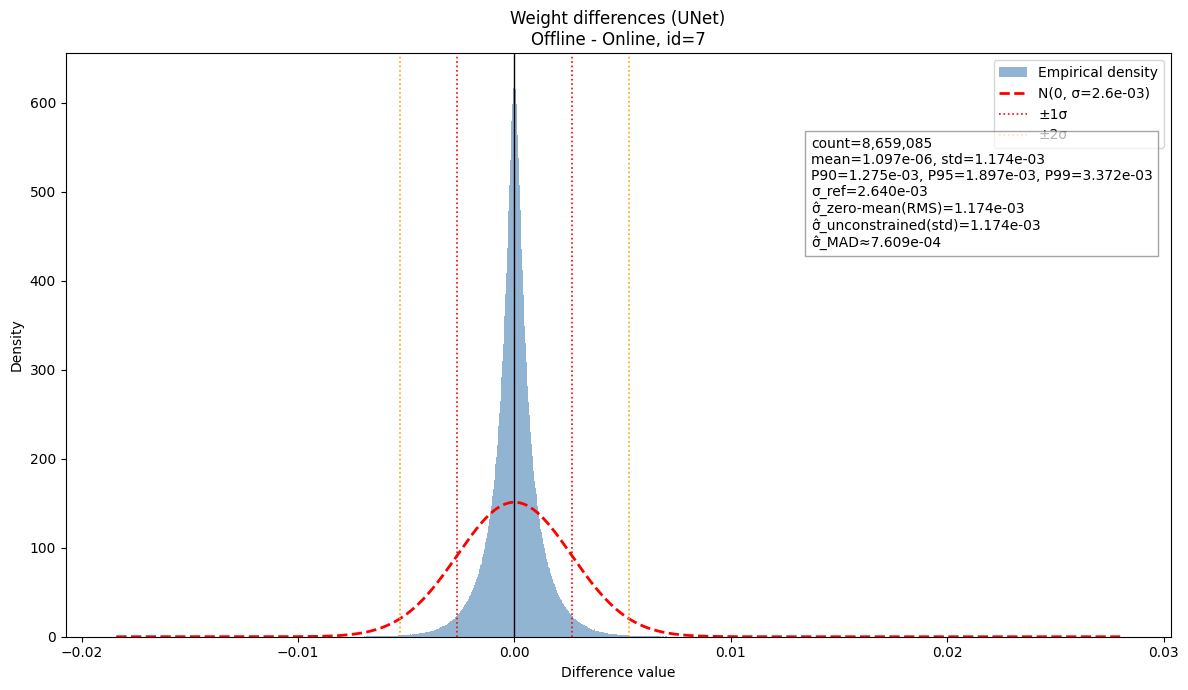

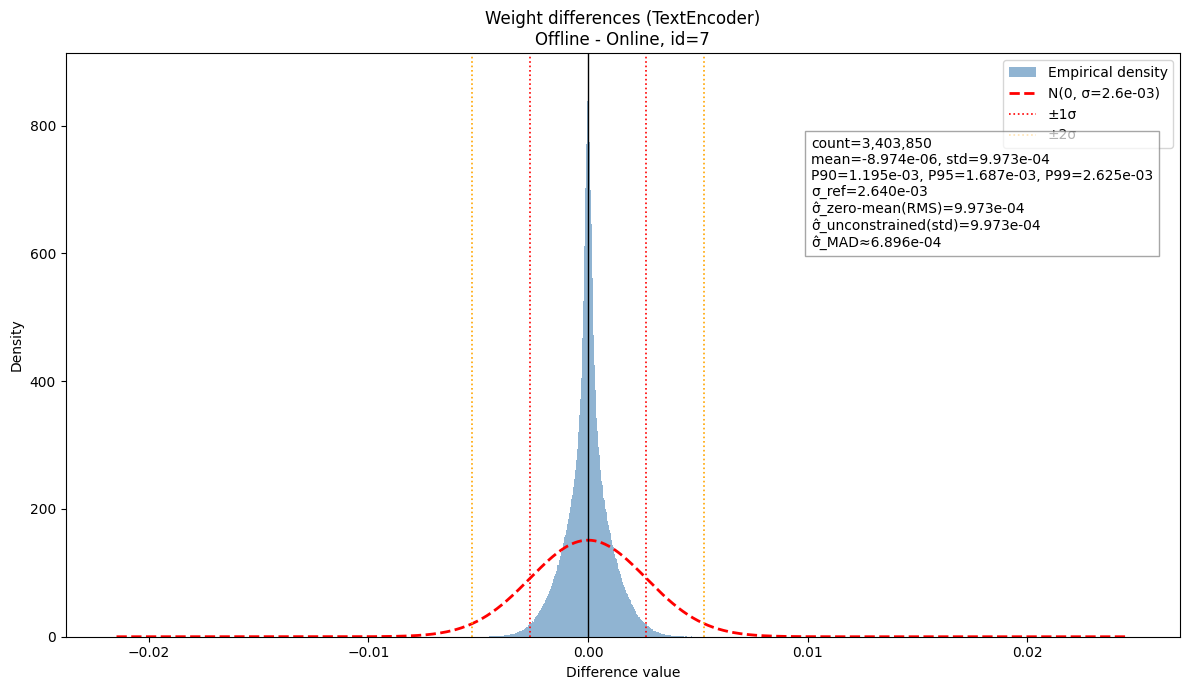

In [4]:
sigma = 2.64e-3*1
SIGMA_UNET = sigma
SIGMA_TEXT = sigma
unet_closest_sigma,text_closest_sigma = plot_param_diff(7, bin_width=2e-5, sample_frac=0.01, sigma_unet=SIGMA_UNET, sigma_text=SIGMA_TEXT, seed=1234)

#### 鲁棒重复采样10+10，sigma1e-3

In [2]:
sigma = 1e-3*1
SIGMA_UNET = sigma
SIGMA_TEXT = sigma
unet_closest_sigma,text_closest_sigma = plot_param_diff(7, bin_width=2e-5, sample_frac=0.01, sigma_unet=SIGMA_UNET, sigma_text=SIGMA_TEXT, seed=1234)

/tmp/ipykernel_777252/844674363.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(pth, map_location="cpu")


[Empty diff skipped] conv_in.weight produced empty difference array.
[Empty diff skipped] conv_in.bias produced empty difference array.
[Empty diff skipped] time_embedding.linear_1.weight produced empty difference array.
[Empty diff skipped] time_embedding.linear_1.bias produced empty difference array.
[Empty diff skipped] time_embedding.linear_2.weight produced empty difference array.
[Empty diff skipped] time_embedding.linear_2.bias produced empty difference array.
[Empty diff skipped] down_blocks.0.attentions.0.norm.weight produced empty difference array.
[Empty diff skipped] down_blocks.0.attentions.0.norm.bias produced empty difference array.
[Empty diff skipped] down_blocks.0.attentions.0.proj_in.weight produced empty difference array.
[Empty diff skipped] down_blocks.0.attentions.0.proj_in.bias produced empty difference array.
[Empty diff skipped] down_blocks.0.attentions.0.transformer_blocks.0.attn1.to_q.weight produced empty difference array.
[Empty diff skipped] down_blocks.0

#### 无鲁棒重复采样权重

/tmp/ipykernel_1879108/3236955479.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(pth, map_location="cpu")


[UNet] best-fit σ (N(0,σ²) MLE) = 1.278234e-02 | unconstrained σ (std) = 1.278234e-02 | robust σ≈1.277432e-02
[TextEncoder] best-fit σ (N(0,σ²) MLE) = 1.274135e-02 | unconstrained σ (std) = 1.274134e-02 | robust σ≈1.273909e-02


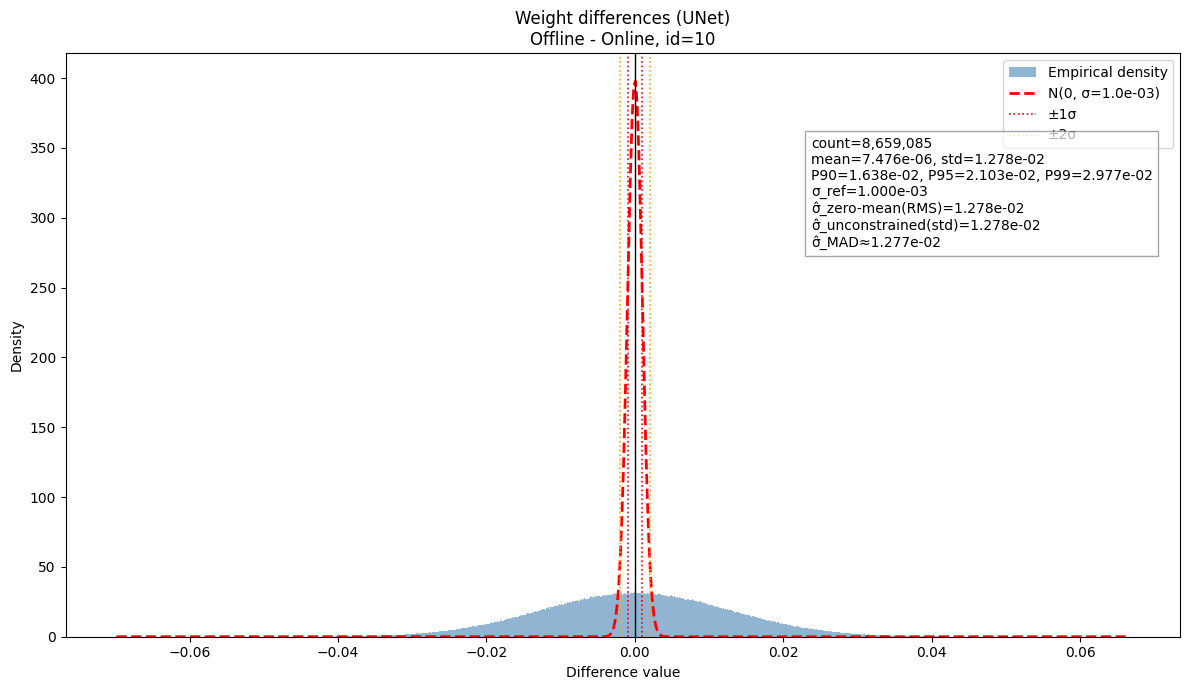

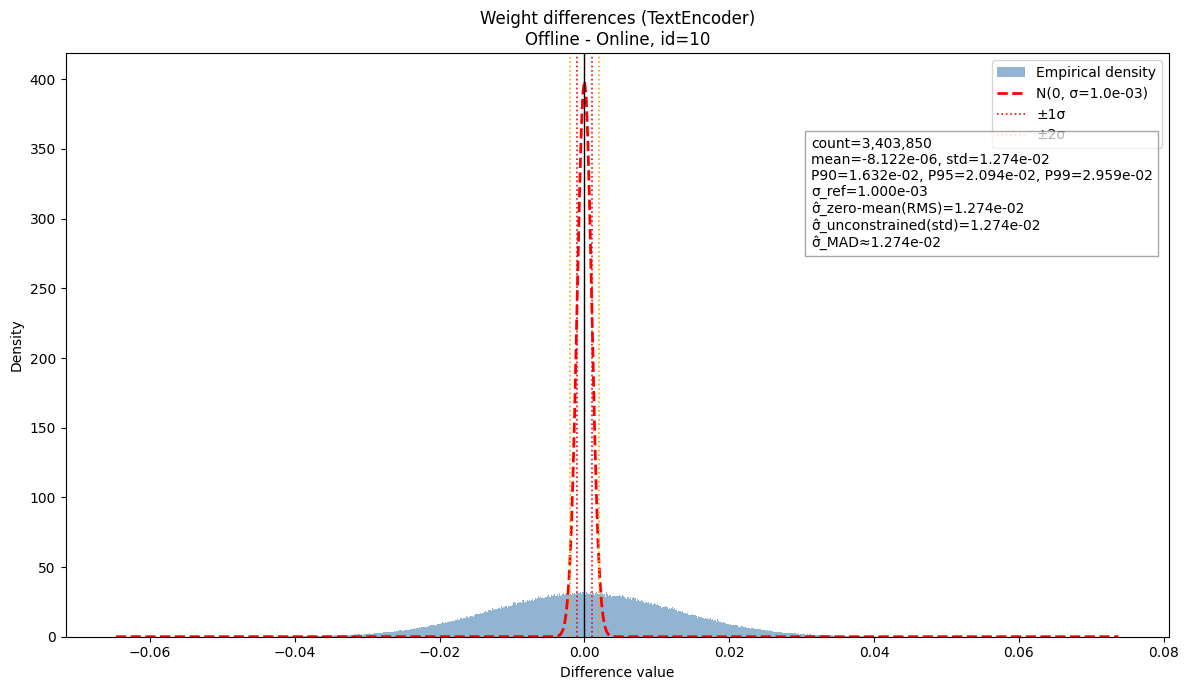

In [ ]:
sigma = 1e-3*1
SIGMA_UNET = sigma
SIGMA_TEXT = sigma
unet_closest_sigma,text_closest_sigma = plot_param_diff(10, bin_width=2e-5, sample_frac=0.01, sigma_unet=SIGMA_UNET, sigma_text=SIGMA_TEXT, seed=1234)

In [6]:
sigma = 1e-3*1
SIGMA_UNET = sigma
SIGMA_TEXT = sigma
UNET_best_sigma = []
TEXT_best_sigma = []
# plot_param_diff(0,sigma_unet=SIGMA_UNET, sigma_text=SIGMA_TEXT)
for id in range(50):
    print(id)
    unet_closest_sigma,text_closest_sigma = plot_param_diff(5, bin_width=2e-5, sample_frac=0.01, sigma_unet=SIGMA_UNET, sigma_text=SIGMA_TEXT, seed=1234)
    UNET_best_sigma.append(unet_closest_sigma)
    TEXT_best_sigma.append(text_closest_sigma)

0


NameError: name 'pairs' is not defined

In [6]:
print(np.mean(UNET_best_sigma))
print(np.mean(TEXT_best_sigma))

0.0008498526294715703
0.0008596869884058833


/tmp/ipykernel_3302712/320615012.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(pth, map_location="cpu")


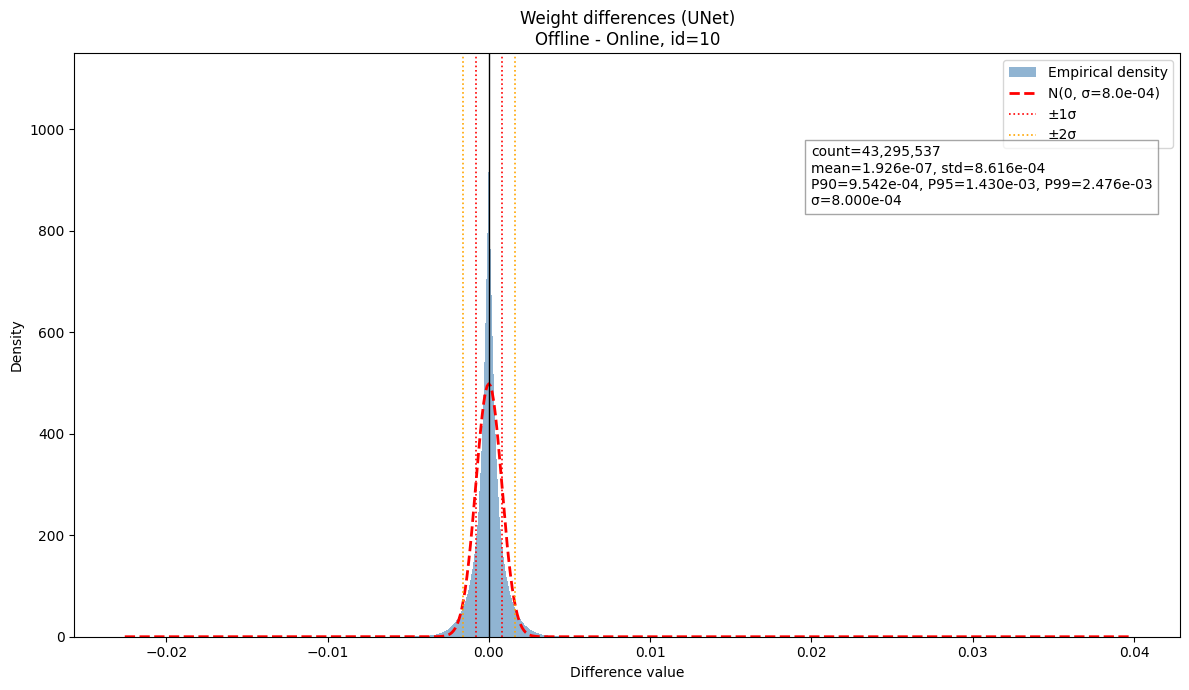

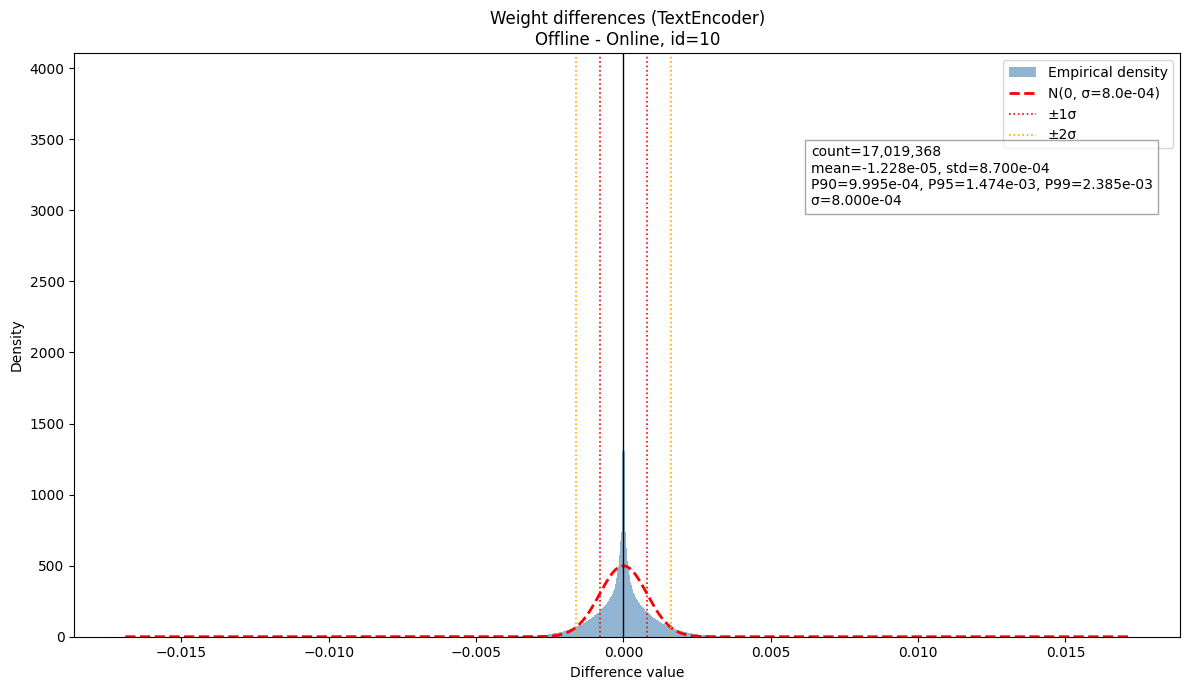

In [5]:
sigma = 1e-3*0.8
SIGMA_UNET = sigma
SIGMA_TEXT = sigma
# plot_param_diff(0,sigma_unet=SIGMA_UNET, sigma_text=SIGMA_TEXT)
plot_param_diff(10, bin_width=2e-5, sample_frac=0.05, sigma_unet=SIGMA_UNET, sigma_text=SIGMA_TEXT, seed=1234)

/tmp/ipykernel_3174589/1354860299.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(pth, map_location="cpu")


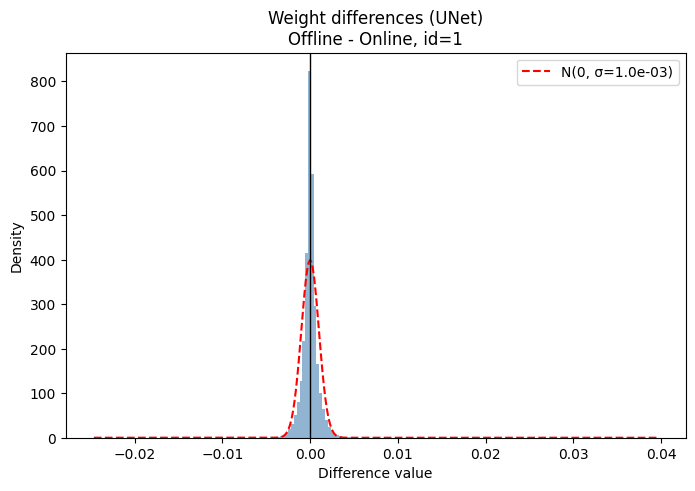

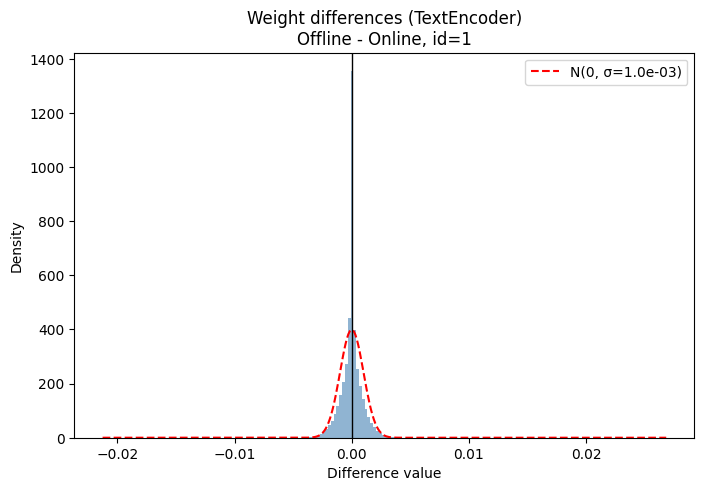

In [ ]:
plot_param_diff(1)

In [1]:
# === 比较 UNet 与 TextEncoder 的偏移尺度（不使用 sigma）===
import os, re, math, glob, json
from pathlib import Path
import torch
import numpy as np
import pandas as pd

# 1) 根目录（填你的绝对路径）
ROOT = Path("/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random50_r8_savemodels_aglr5e-5").resolve()
assert ROOT.exists(), f"根目录不存在: {ROOT}"

# -------------------- 工具函数 --------------------
def _strip_module_prefix(sd: dict):
    if any(k.startswith("module.") for k in sd.keys()):
        return {k.replace("module.", "", 1): v for k, v in sd.items()}
    return sd

def load_sd(pth: Path):
    obj = torch.load(pth, map_location="cpu")
    if isinstance(obj, dict) and "state_dict" in obj and isinstance(obj["state_dict"], dict):
        obj = obj["state_dict"]
    return _strip_module_prefix(obj)

def latest_checkpoint_dir(train_output_dir: Path):
    # 形如 checkpoint-2000、checkpoint-3000 ... 选步数最大的
    cands = sorted([p for p in train_output_dir.glob("checkpoint-*") if p.is_dir()],
                   key=lambda p: int(re.findall(r"checkpoint-(\d+)", p.name)[0]),
                   reverse=True)
    return cands[0] if len(cands) else None

def find_pairs(root: Path):
    """返回每个 id 的在线/离线 UNet/TextEncoder 路径字典列表"""
    pairs = []
    for d in sorted(root.glob("exp_data_ASPL-id*-r8-steps50-*")):
        if not d.is_dir(): 
            continue
        on_unet = d / "models" / "50" / "unet.pth"
        on_text = d / "models" / "50" / "text_encoder.pth"
        train_out = d / "train_output"
        ckpt_dir = latest_checkpoint_dir(train_out) if train_out.exists() else None
        off_unet = ckpt_dir / "unet" / "diffusion_pytorch_model.bin" if ckpt_dir else None
        off_text = ckpt_dir / "text_encoder" / "pytorch_model.bin" if ckpt_dir else None

        ok = all([on_unet and on_unet.exists(),
                  on_text and on_text.exists(),
                  off_unet and off_unet.exists(),
                  off_text and off_text.exists()])
        if not ok:
            print(f"[WARN] 跳过（缺文件）: {d}")
            continue

        m = re.search(r"exp_data_ASPL-id(\d+)-r8-steps50-\d+", d.name)
        id_ = int(m.group(1)) if m else None
        pairs.append({
            "id": id_,
            "root": str(d),
            "on_unet": str(on_unet),
            "on_text": str(on_text),
            "off_unet": str(off_unet),
            "off_text": str(off_text),
            "ckpt": ckpt_dir.name if ckpt_dir else None
        })
    return sorted(pairs, key=lambda x: (x["id"] if x["id"] is not None else 1e9))

def block_diff_stats(off_sd: dict, on_sd: dict):
    """
    只在 key 存在且 shape 一致处累计：
    - L2 总范数: sqrt(sum diff^2)
    - 全局 RMS: sqrt(mean diff^2)
    - 相对 RMS: RMS(diff) / RMS(off)
    - max|diff|
    - 参数总数
    """
    sum_sq_diff = 0.0
    sum_sq_off  = 0.0
    n_params    = 0
    max_abs     = 0.0
    matched     = 0
    missing     = 0
    for k, w_off in off_sd.items():
        w_on = on_sd.get(k, None)
        if w_on is None or w_off.shape != w_on.shape:
            missing += 1
            continue
        matched += 1
        diff = (w_on - w_off).float()
        sum_sq_diff += float((diff ** 2).sum().item())
        sum_sq_off  += float((w_off.float() ** 2).sum().item())
        n_params    += diff.numel()
        max_abs      = max(max_abs, float(diff.abs().max().item()))
    l2 = math.sqrt(sum_sq_diff) if sum_sq_diff > 0 else 0.0
    rms_diff = math.sqrt(sum_sq_diff / n_params) if n_params > 0 else 0.0
    rms_off  = math.sqrt(sum_sq_off / n_params) if n_params > 0 else 0.0
    rel_rms  = (rms_diff / (rms_off + 1e-12)) if rms_off > 0 else float('inf')
    return {
        "l2": l2,
        "rms_diff": rms_diff,
        "rms_off": rms_off,
        "rel_rms": rel_rms,
        "max_abs": max_abs,
        "n_params": n_params,
        "keys_matched": matched,
        "keys_missing": missing
    }

# -------------------- 主流程 --------------------
pairs = find_pairs(ROOT)
print(f"发现配对: {len(pairs)} 组")
assert len(pairs) > 0, "没有发现有效的模型配对，请检查路径"

rows = []
for it in pairs:
    id_ = it["id"]
    onU  = load_sd(it["on_unet"])
    onT  = load_sd(it["on_text"])
    offU = load_sd(it["off_unet"])
    offT = load_sd(it["off_text"])

    stat_U = block_diff_stats(offU, onU)  # 在线 - 离线（UNet）
    stat_T = block_diff_stats(offT, onT)  # 在线 - 离线（Text）

    rows.append({
        "id": id_,
        "dir": it["root"],
        "ckpt": it["ckpt"],
        # UNet
        "unet_l2": stat_U["l2"],
        "unet_rms_diff": stat_U["rms_diff"],
        "unet_rms_off": stat_U["rms_off"],
        "unet_rel_rms": stat_U["rel_rms"],
        "unet_max_abs": stat_U["max_abs"],
        "unet_params": stat_U["n_params"],
        "unet_keys_matched": stat_U["keys_matched"],
        "unet_keys_missing": stat_U["keys_missing"],
        # Text
        "text_l2": stat_T["l2"],
        "text_rms_diff": stat_T["rms_diff"],
        "text_rms_off": stat_T["rms_off"],
        "text_rel_rms": stat_T["rel_rms"],
        "text_max_abs": stat_T["max_abs"],
        "text_params": stat_T["n_params"],
        "text_keys_matched": stat_T["keys_matched"],
        "text_keys_missing": stat_T["keys_missing"],
        # 粗略对比
        "l2_ratio_unet_over_text": (stat_U["l2"] / (stat_T["l2"] + 1e-12)) if stat_T["l2"] > 0 else float('inf'),
        "rms_ratio_unet_over_text": (stat_U["rms_diff"] / (stat_T["rms_diff"] + 1e-12)) if stat_T["rms_diff"] > 0 else float('inf'),
        "rel_rms_ratio_unet_over_text": (stat_U["rel_rms"] / (stat_T["rel_rms"] + 1e-12)) if stat_T["rel_rms"] > 0 else float('inf'),
    })

df = pd.DataFrame(rows).sort_values("id").reset_index(drop=True)
display(df.head())
display(df[[
    "unet_rms_diff","text_rms_diff","unet_rel_rms","text_rel_rms",
    "l2_ratio_unet_over_text","rms_ratio_unet_over_text","rel_rms_ratio_unet_over_text"
]].describe())

# 保存结果
# out_dir = ROOT / "eta_sizing"
# out_dir.mkdir(parents=True, exist_ok=True)
# csv_path = out_dir / "raw_offset_scales.csv"
# df.to_csv(csv_path, index=False)
# print(f"已保存: {csv_path}")

发现配对: 50 组


/tmp/ipykernel_3302712/2225186647.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  obj = torch.load(pth, map_location="cpu")


,id,dir,ckpt,unet_l2,unet_rms_diff,unet_rms_off,unet_rel_rms,unet_max_abs,unet_params,unet_keys_matched,...,text_rms_diff,text_rms_off,text_rel_rms,text_max_abs,text_params,text_keys_matched,text_keys_missing,l2_ratio_unet_over_text,rms_ratio_unet_over_text,rel_rms_ratio_unet_over_text
0,0,/data/home/yekai/github/DiffAdvPerturbationBen...,checkpoint-2000,25.377832,0.000862,0.040667,0.021207,0.039462,865910724,686,...,0.000845,0.032481,0.026029,0.030994,340387917,373,0,1.627002,1.020090,0.814750
1,1,/data/home/yekai/github/DiffAdvPerturbationBen...,checkpoint-2000,24.821387,0.000844,0.040666,0.020742,0.039595,865910724,686,...,0.000847,0.032480,0.026078,0.026836,340387917,373,0,1.588320,0.995838,0.795380
2,2,/data/home/yekai/github/DiffAdvPerturbationBen...,checkpoint-2000,25.083855,0.000852,0.040666,0.020961,0.043520,865910724,686,...,0.000842,0.032480,0.025919,0.026670,340387917,373,0,1.614966,1.012544,0.808722
3,3,/data/home/yekai/github/DiffAdvPerturbationBen...,checkpoint-2000,25.061039,0.000852,0.040666,0.020942,0.041023,865910724,686,...,0.000857,0.032480,0.026398,0.026462,340387917,373,0,1.584206,0.993258,0.793318
4,4,/data/home/yekai/github/DiffAdvPerturbationBen...,checkpoint-2000,25.304947,0.000860,0.040666,0.021146,0.040469,865910724,686,...,0.000869,0.032480,0.026749,0.025983,340387917,373,0,1.578677,0.989792,0.790551


,unet_rms_diff,text_rms_diff,unet_rel_rms,text_rel_rms,l2_ratio_unet_over_text,rms_ratio_unet_over_text,rel_rms_ratio_unet_over_text
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.000852,0.000851,0.020939,0.026197,1.596268,1.000821,0.799360
std,0.000007,0.000010,0.000177,0.000310,0.018162,0.011387,0.009095
min,0.000839,0.000831,0.020633,0.025588,1.564498,0.980902,0.783449
25%,0.000846,0.000844,0.020809,0.025982,1.580217,0.990757,0.791321
50%,0.000850,0.000850,0.020914,0.026179,1.595544,1.000367,0.798996
75%,0.000856,0.000857,0.021061,0.026394,1.607996,1.008174,0.805234
max,0.000869,0.000879,0.021379,0.027059,1.636311,1.025927,0.819410


#### 先看看在线模型和离线模型的参数差分布：离线-在线

In [ ]:
# === 对每个 id 的 UNet/TextEncoder 计算 “离线-在线” 权重差分的正负分布，并可视化 ===
import os, re, math
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd

# 1) 根目录（填你的绝对路径）
ROOT = Path("/data/home/yekai/github/DiffAdvPerturbationBench/Algorithms/Anti-DreamBooth/exp_datas_output/aspl_VGGFace2_SD21_random50_r8_savemodels_aglr5e-5").resolve()
assert ROOT.exists(), f"根目录不存在: {ROOT}"

# 2) 输出目录
OUT_DIR = ROOT / "wdelta_reports"
IMG_DIR = OUT_DIR / "figs"
OUT_DIR.mkdir(parents=True, exist_ok=True)
IMG_DIR.mkdir(parents=True, exist_ok=True)

# 3) 直方图设置
BINS = 201                  # 奇数个 bins，保证 0 在中间
RANGE_PAD_RATIO = 1.02      # 在最大绝对差的基础上扩一点点，防止卡边

# -------------------- 基础 I/O --------------------
def _strip_module_prefix(sd: dict):
    if any(k.startswith("module.") for k in sd.keys()):
        return {k.replace("module.", "", 1): v for k, v in sd.items()}
    return sd

def load_sd(pth: Path):
    obj = torch.load(pth, map_location="cpu")
    if isinstance(obj, dict) and "state_dict" in obj and isinstance(obj["state_dict"], dict):
        obj = obj["state_dict"]
    return _strip_module_prefix(obj)

def latest_checkpoint_dir(train_output_dir: Path):
    cands = []
    for p in train_output_dir.glob("checkpoint-*"):
        if p.is_dir():
            m = re.search(r"checkpoint-(\d+)", p.name)
            if m: cands.append((int(m.group(1)), p))
    if not cands:
        return None
    cands.sort(key=lambda x: x[0])   # 按步数升序
    return cands[-1][1]              # 返回最后（步数最大）

def find_pairs(root: Path):
    """为每个 id 返回：在线/离线 UNet/TextEncoder 的权重路径"""
    pairs = []
    for d in sorted(root.glob("exp_data_ASPL-id*-r8-steps50-*")):
        if not d.is_dir(): 
            continue
        on_unet = d / "models" / "50" / "unet.pth"
        on_text = d / "models" / "50" / "text_encoder.pth"
        ckpt_dir = latest_checkpoint_dir(d / "train_output")
        off_unet = ckpt_dir / "unet" / "diffusion_pytorch_model.bin" if ckpt_dir else None
        off_text = ckpt_dir / "text_encoder" / "pytorch_model.bin" if ckpt_dir else None

        ok = all([on_unet and on_unet.exists(),
                  on_text and on_text.exists(),
                  off_unet and off_unet.exists(),
                  off_text and off_text.exists()])
        if not ok:
            print(f"[WARN] 跳过（缺文件）: {d}")
            continue

        m = re.search(r"exp_data_ASPL-id(\d+)-r8-steps50-\d+", d.name)
        id_ = int(m.group(1)) if m else None
        pairs.append({
            "id": id_,
            "exp_dir": d,
            "ckpt_name": ckpt_dir.name if ckpt_dir else None,
            "on_unet": on_unet, "on_text": on_text,
            "off_unet": off_unet, "off_text": off_text,
        })
    return sorted(pairs, key=lambda x: (x["id"] if x["id"] is not None else 1e9))

# -------------------- 核心：两遍扫描做直方图 --------------------
def scan_max_abs_diff(sd_off: dict, sd_on: dict) -> float:
    """第一遍：求所有匹配张量的最大 |off - on| 值"""
    max_abs = 0.0
    for k, w_off in sd_off.items():
        w_on = sd_on.get(k, None)
        if w_on is None or w_on.shape != w_off.shape:
            continue
        d = (w_off.float() - w_on.float()).abs().max().item()
        if d > max_abs:
            max_abs = d
    return float(max_abs)

def hist_pos_neg(sd_off: dict, sd_on: dict, bins: int, range_tuple: tuple):
    """
    第二遍：用固定 bins/range 统计 >0 与 <0 两个直方图（不存全量差值）
    返回 (bin_edges, counts_pos, counts_neg, zero_count)
    """
    lo, hi = range_tuple
    assert lo < 0 < hi
    counts_pos = np.zeros(bins, dtype=np.int64)
    counts_neg = np.zeros(bins, dtype=np.int64)
    zero_count = 0

    for k, w_off in sd_off.items():
        w_on = sd_on.get(k, None)
        if w_on is None or w_on.shape != w_off.shape:
            continue
        diff = (w_off.float() - w_on.float()).view(-1)
        # 正负分开
        pos = diff[diff > 0]
        neg = diff[diff < 0]
        zero_count += int((diff == 0).sum().item())
        if pos.numel():
            h, edges = np.histogram(pos.cpu().numpy(), bins=bins, range=(lo, hi))
            counts_pos += h
        if neg.numel():
            h, edges = np.histogram(neg.cpu().numpy(), bins=bins, range=(lo, hi))
            counts_neg += h

    return edges, counts_pos, counts_neg, zero_count

def approx_quantile_from_hist(edges, counts, q):
    """根据直方图近似分位（左闭右开）；q∈[0,1]"""
    counts = counts.astype(np.float64)
    cdf = counts.cumsum()
    total = cdf[-1]
    if total == 0: 
        return 0.0
    target = q * total
    idx = np.searchsorted(cdf, target, side="left")
    idx = np.clip(idx, 0, len(edges) - 2)
    # 线性内插
    left_edge, right_edge = edges[idx], edges[idx+1]
    left_count = cdf[idx-1] if idx > 0 else 0.0
    bin_count = counts[idx]
    if bin_count <= 0:
        return left_edge
    frac = (target - left_count) / bin_count
    return float(left_edge + (right_edge - left_edge) * np.clip(frac, 0.0, 1.0))

def summarize_from_hist(edges, counts):
    """从直方图近似统计：count, min, max, p50, p90, p95, mean, std"""
    total = counts.sum()
    if total == 0:
        return dict(count=0, min=np.nan, max=np.nan, p50=np.nan, p90=np.nan, p95=np.nan, mean=np.nan, std=np.nan)
    # 近似均值/方差：用箱中心点做权重
    centers = 0.5 * (edges[:-1] + edges[1:])
    mean = float((centers * counts).sum() / total)
    var = float((((centers - mean) ** 2) * counts).sum() / total)
    return dict(
        count=int(total),
        min=float(edges[0]),
        max=float(edges[-1]),
        p50=approx_quantile_from_hist(edges, counts, 0.5),
        p90=approx_quantile_from_hist(edges, counts, 0.9),
        p95=approx_quantile_from_hist(edges, counts, 0.95),
        mean=mean,
        std=math.sqrt(max(var, 0.0)),
    )

# -------------------- 主流程：逐 id 处理并绘图 --------------------
pairs = find_pairs(ROOT)
print(f"发现有效实验数: {len(pairs)}")

all_rows = []
for it in pairs:
    id_ = it["id"]
    # 载入
    sd_on_u  = load_sd(it["on_unet"])
    sd_on_t  = load_sd(it["on_text"])
    sd_off_u = load_sd(it["off_unet"])
    sd_off_t = load_sd(it["off_text"])

    # —— UNet：两遍扫描 —— 
    max_abs_u = max(
        1e-12,
        scan_max_abs_diff(sd_off_u, sd_on_u)
    )
    rng_u = (-max_abs_u*RANGE_PAD_RATIO, max_abs_u*RANGE_PAD_RATIO)
    edges_u, pos_u, neg_u, zero_u = hist_pos_neg(sd_off_u, sd_on_u, BINS, rng_u)

    # —— Text：两遍扫描 —— 
    max_abs_t = max(
        1e-12,
        scan_max_abs_diff(sd_off_t, sd_on_t)
    )
    rng_t = (-max_abs_t*RANGE_PAD_RATIO, max_abs_t*RANGE_PAD_RATIO)
    edges_t, pos_t, neg_t, zero_t = hist_pos_neg(sd_off_t, sd_on_t, BINS, rng_t)

    # 统计
    sum_pos_u = summarize_from_hist(edges_u, pos_u)
    sum_neg_u = summarize_from_hist(edges_u, neg_u)
    sum_pos_t = summarize_from_hist(edges_t, pos_t)
    sum_neg_t = summarize_from_hist(edges_t, neg_t)

    all_rows.append({
        "id": id_, "ckpt": it["ckpt_name"],
        "block": "unet",
        "pos_count": sum_pos_u["count"], "neg_count": sum_neg_u["count"], "zero_count": zero_u,
        "pos_p50": sum_pos_u["p50"], "pos_p90": sum_pos_u["p90"], "pos_p95": sum_pos_u["p95"],
        "neg_p50": sum_neg_u["p50"], "neg_p90": sum_neg_u["p90"], "neg_p95": sum_neg_u["p95"],
        "pos_mean": sum_pos_u["mean"], "pos_std": sum_pos_u["std"],
        "neg_mean": sum_neg_u["mean"], "neg_std": sum_neg_u["std"],
        "range_min": edges_u[0], "range_max": edges_u[-1],
    })
    all_rows.append({
        "id": id_, "ckpt": it["ckpt_name"],
        "block": "text",
        "pos_count": sum_pos_t["count"], "neg_count": sum_neg_t["count"], "zero_count": zero_t,
        "pos_p50": sum_pos_t["p50"], "pos_p90": sum_pos_t["p90"], "pos_p95": sum_pos_t["p95"],
        "neg_p50": sum_neg_t["p50"], "neg_p90": sum_neg_t["p90"], "neg_p95": sum_neg_t["p95"],
        "pos_mean": sum_pos_t["mean"], "pos_std": sum_pos_t["std"],
        "neg_mean": sum_neg_t["mean"], "neg_std": sum_neg_t["std"],
        "range_min": edges_t[0], "range_max": edges_t[-1],
    })

    # —— 画图（UNet）——
    centers_u = 0.5 * (edges_u[:-1] + edges_u[1:])
    plt.figure(figsize=(8,4.5))
    plt.title(f"UNet ΔW (offline - online) | id={id_} | {it['ckpt_name']}")
    plt.bar(centers_u, pos_u, width=(centers_u[1]-centers_u[0]), alpha=0.6, label="> 0")
    plt.bar(centers_u, neg_u, width=(centers_u[1]-centers_u[0]), alpha=0.6, label="< 0")
    plt.axvline(0.0, linestyle="--")
    # 使 0 在中间：对称 x 轴范围
    xmax = max(abs(edges_u[0]), abs(edges_u[-1]))
    plt.xlim(-xmax, xmax)
    plt.xlabel("weight diff (offline - online)")
    plt.ylabel("count")
    plt.legend()
    save_u = IMG_DIR / f"id{id_:03d}_unet_hist.png"
    plt.tight_layout()
    plt.savefig(save_u, dpi=140)
    plt.close()

    # —— 画图（TextEncoder）——
    centers_t = 0.5 * (edges_t[:-1] + edges_t[1:])
    plt.figure(figsize=(8,4.5))
    plt.title(f"TextEncoder ΔW (offline - online) | id={id_} | {it['ckpt_name']}")
    plt.bar(centers_t, pos_t, width=(centers_t[1]-centers_t[0]), alpha=0.6, label="> 0")
    plt.bar(centers_t, neg_t, width=(centers_t[1]-centers_t[0]), alpha=0.6, label="< 0")
    plt.axvline(0.0, linestyle="--")
    xmax = max(abs(edges_t[0]), abs(edges_t[-1]))
    plt.xlim(-xmax, xmax)
    plt.xlabel("weight diff (offline - online)")
    plt.ylabel("count")
    plt.legend()
    save_t = IMG_DIR / f"id{id_:03d}_text_hist.png"
    plt.tight_layout()
    plt.savefig(save_t, dpi=140)
    plt.close()

# # 汇总表保存
# df = pd.DataFrame(all_rows).sort_values(["id","block"]).reset_index(drop=True)
# csv_path = OUT_DIR / "delta_distributions_summary.csv"
# df.to_csv(csv_path, index=False)
# print(f"完成。统计表: {csv_path}\n图像输出目录: {IMG_DIR}")